# Imports Libraries

In [1]:
import os
import sklearn as sk
import numpy as np
from numpy.random import shuffle
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import (
    SVC,
)  # SVM is not going to work. After 150.000 samples is almsot impossible to run
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from collections import Counter

# Functions

In [2]:
def crawl_directory(directory: str) -> list:
    """Crawling data directory
    Args:
        directory (str) : The directory to crawl
    Returns:
        tree (list)     : A list with all the filepaths
    """
    tree = []
    subdirs = [folder[0] for folder in os.walk(directory)]

    for subdir in subdirs:
        files = next(os.walk(subdir))[2]
        for _file in files:
            tree.append(os.path.join(subdir, _file))

    return tree

In [3]:
def unique_files(tree: list) -> set:
    """
    Getting the unique file names from a list
    """
    sunolo = set()
    for i in tree:
        sunolo.add(i.split(os.sep)[-1].split(".")[0])
    return sunolo

In [4]:
def load_npys_to_matrics(
    labels: list, videos: list, audio: list, threshold: int = 0.6
) -> tuple:
    """
    Loading the numpy files. Visual and audio will be averaged every 5 and 10 rows respectively.
    DISCLAIMER i keep the minimum number of samples between the same video file from label, video and audio features matrices.
    """
    STATS = {}
    print("Nunpy to Matrices have start")
    files_sizes = []
    labels_matrix = []
    visual_matrix = []
    audio_matrix = []
    if not len(labels) == len(videos) == len(audio):
        raise Exception("Labels, visual features and audio have not the same size")
    for idx in range(len(labels)):
        # load labels, visual and audio in temporary variables
        try:
            tmp_label = np.load(labels[idx])

            # 1 if the timestamp have been annotated at least from the half annotators of that specific file
            max_annotators = int(np.amax(tmp_label))

            if max_annotators < 3:
                continue

            tmp_label[tmp_label / max_annotators < threshold] = 0
            tmp_label[tmp_label / max_annotators >= threshold] = 1

            tmp_label[tmp_label >= max_annotators] = 1

            tmp_visual = np.load(videos[idx])
            tmp_audio = np.load(
                audio[idx]
            ).transpose()  # transposed to the same format of visual features (rows = samplles, columns = features)
            if not max_annotators in STATS.keys():
                STATS[max_annotators] = 0
            STATS[max_annotators] += 1
        except ValueError:
            print(f"File in index {idx} with name {videos[idx]} Not loaded")
            continue

        # get min seconds from the same label, visual, audio np file
        l_r = tmp_label.shape[0]
        v_r, v_c = tmp_visual.shape
        a_r, a_c = tmp_audio.shape

        v_r = v_r // 5
        min_seconds = min(l_r, v_r, a_r)

        files_sizes.append(min_seconds)

        labels_matrix.append(tmp_label[:min_seconds])
        # VISUAL
        # keep number of samples divisible with 5
        tmp_visual = tmp_visual[: min_seconds * 5]
        # averaging visual every 5 (Because we have analyze video with .2 step)
        visual_matrix.append(
            tmp_visual.transpose().reshape(-1, 5).mean(1).reshape(v_c, -1).transpose()
        )

        tmp_audio = tmp_audio[:min_seconds]
        audio_matrix.append(tmp_audio)

        del tmp_label
        del tmp_visual
        del tmp_audio

    # print(STATS)
    return files_sizes, labels_matrix, visual_matrix, audio_matrix

In [5]:
def split(labels: list, videos: list, audio: list, split_size: float) -> tuple:
    if not len(labels) == len(videos) == len(audio):
        raise Exception("Labels, visual features and audio have not the same size")
    if split_size >= 1.0 or split_size <= 0.0:
        raise Exception("Split size is out of bound")
    trainining_size = int(split_size * len(labels))
    # first training, second test
    return (
        np.hstack([label for label in labels[:trainining_size]]),
        np.vstack([video for video in videos[:trainining_size]]),
        np.vstack([audio for audio in audio[:trainining_size]]),
        np.hstack([label for label in labels[trainining_size:]]),
        np.vstack([video for video in videos[trainining_size:]]),
        np.vstack([audio for audio in audio[trainining_size:]]),
    )

In [6]:
def shuffle_lists(labels: list, audio: list, visual: list) -> tuple:
    np.random.seed(47)
    zipped_list = list(zip(labels, audio, visual))
    shuffle(
        zipped_list,
    )
    return zip(*zipped_list)

In [7]:
def grid_search(model, params, param_name, x_train, y_train, x_test, y_test):
    best_score = 0
    for param in params:
        a = {param_name: param}
        model.set_params(**a)
        model.fit(x_train, y_train)
        preds_prob = model.predict_proba(x_test)
        score = roc_auc_score(y_test, preds_prob[:, 1])
        print("{} = {}: {}".format(param_name, param, score))
        # save if best
        if score > best_score:
            best_score = score
            best_param = param
    print("Best score: {}".format(best_score))
    print("Best param: {}".format(best_param))
    return best_param

# Main Logic 

In [8]:
plots = {}

In [9]:
labels_path = os.path.join("CLEAN_FEATURES", "labels_4_2_21")
video_features = os.path.join("CLEAN_FEATURES", "visual_features")
audio_features = os.path.join("CLEAN_FEATURES", "audio_features")

In [10]:
print("Crawling data paths")

Crawling data paths


In [11]:
labels_tree = crawl_directory(labels_path)
videos_tree = crawl_directory(video_features)
audio_tree = crawl_directory(audio_features)

In [12]:
print("Total Number of features and annotations")

Total Number of features and annotations


In [13]:
print("Labels len: ", len(labels_tree))
print("Audio len: ", len(audio_tree))
print("Video len: ", len(videos_tree))

Labels len:  410
Audio len:  410
Video len:  410


In [14]:
print("Sorting both lists with paths, in order to be in parallel")

Sorting both lists with paths, in order to be in parallel


In [15]:
# Sorting files lists in order to be in parallel

labels_tree.sort()
videos_tree.sort()
audio_tree.sort()

In [16]:
len(labels_tree) == len(videos_tree) == len(audio_tree)

True

Tranformations


In [17]:
# shuffling files lists in parallel
labels_tree, audio_tree, videos_tree = shuffle_lists(
    labels_tree, audio_tree, videos_tree
)

Loading Matrices 

In [18]:
%%time
files_sizes, labels_matrix, visual_matrix, audio_matrix = load_npys_to_matrics(
    labels_tree, videos_tree, audio_tree
)

Nunpy to Matrices have start
File in index 398 with name CLEAN_FEATURES/visual_features/downhill/Matt Jones - DOWNHILL BRAKELESS BMX IS DANGEROUS!!.mp4.npy Not loaded
CPU times: user 1.2 s, sys: 420 ms, total: 1.62 s
Wall time: 3.22 s


In [19]:
len(visual_matrix)

336

In [20]:
len(audio_matrix)

336

In [21]:
train_labels, train_visual, train_audio, test_labels, test_visual, test_audio = split(
    labels_matrix, visual_matrix, audio_matrix, 0.8
)

In [22]:
print("TRAIN SHAPES")
print(f"Labels Shape {train_labels.shape}")
print(f"Visual Shape {train_visual.shape}")
print(f"Audio Shape {train_audio.shape}")

TRAIN SHAPES
Labels Shape (127972,)
Visual Shape (127972, 88)
Audio Shape (127972, 136)


In [23]:
print("TEST SHAPES")
print(f"Labels Shape {test_labels.shape}")
print(f"Visual Shape {test_visual.shape}")
print(f"Audio Shape {test_audio.shape}")

TEST SHAPES
Labels Shape (31113,)
Visual Shape (31113, 88)
Audio Shape (31113, 136)


In [24]:
scaler_1 = StandardScaler()
train_audio = scaler_1.fit_transform(train_audio)

test_audio = scaler_1.transform(test_audio)

scaler_2 = StandardScaler()
train_visual = scaler_2.fit_transform(train_visual)

test_visual = scaler_2.transform(test_visual)

train_union = np.concatenate((train_audio, train_visual), axis=1)
test_union = np.concatenate((test_audio, test_visual), axis=1)

# Random  Experiment

In [79]:
random_pred_probs = np.random.rand(test_audio.shape[0], 1)

In [80]:
random_pred_probs = np.concatenate((random_pred_probs, 1 - random_pred_probs), axis=1)

In [81]:
random_pred_probs

array([[0.26311827, 0.73688173],
       [0.1201094 , 0.8798906 ],
       [0.527481  , 0.472519  ],
       ...,
       [0.50671844, 0.49328156],
       [0.68807473, 0.31192527],
       [0.70738536, 0.29261464]])

In [82]:
random_preds = random_pred_probs.copy()
random_preds[random_preds > 0.5] = 1
random_preds[random_preds <= 0.5] = 0

In [83]:
test_labels

array([0, 0, 0, ..., 0, 0, 0])

In [84]:
random_preds[:, 1]

array([1., 1., 0., ..., 0., 0., 0.])

In [87]:
print(
    f"Random F1 is: {f1_score(test_labels, random_preds[:, 1], average='macro') * 100:.2f} %"
)

Random F1 is: 47.60 %


In [88]:
print("ROC AUC score: {}".format(roc_auc_score(test_labels, random_pred_probs[:, 1])))

ROC AUC score: 0.49672420398891404


In [55]:
print(
    f" Confusion Matrix for Random :\n {confusion_matrix(test_labels, random_preds[:, 1])}"
)

 Confusion Matrix for Random :
 [[10868 10879]
 [ 4679  4687]]


In [58]:
plots["Random"] = roc_curve(test_labels, random_pred_probs[:, 1])

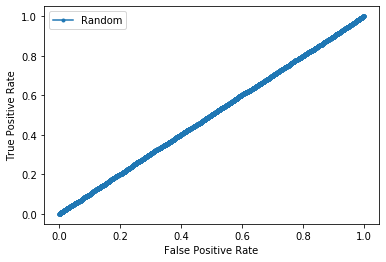

In [59]:
fpr, tpr, _ = roc_curve(test_labels, random_pred_probs[:, 1])
pyplot.plot(fpr, tpr, marker=".", label="Random")
pyplot.xlabel("False Positive Rate")
pyplot.ylabel("True Positive Rate")
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

## Logistic Regression

In [72]:
model = LogisticRegression(solver="lbfgs", max_iter=100000, random_state=42)
C_param_range = {0.001, 0.01, 0.1, 1, 10, 100, 1000}
c = grid_search(
    model, C_param_range, "C", train_audio, train_labels, test_audio, test_labels
)
audio_lR = LogisticRegression(C=c, solver="lbfgs", max_iter=100000, random_state=42)
audio_lR.fit(train_audio, train_labels)
preds = audio_lR.predict(test_audio)
print(
    f"--> F1: Logistic Regression on Audio features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = audio_lR.predict_proba(test_audio)
print(
    f"--> ROC AUC: Logistic Regression on Audio features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

C = 0.1: 0.6276153916330975
C = 1: 0.6276151412432773
C = 100: 0.6276149546783133
C = 1000: 0.6276128042716228
C = 10: 0.627610103989249
C = 0.01: 0.6273993837719962
C = 0.001: 0.6252322304211633
Best score: 0.6276153916330975
Best param: 0.1
--> F1: Logistic Regression on Audio features only  is: 41.40 %
--> ROC AUC: Logistic Regression on Audio features only  is: 62.76 %


In [73]:
model = LogisticRegression(solver="lbfgs", max_iter=100000, random_state=42)
C_param_range = {0.001, 0.01, 0.1, 1, 10, 100, 1000}
c = grid_search(
    model, C_param_range, "C", train_visual, train_labels, test_visual, test_labels
)
visual_lR = LogisticRegression(C=c, solver="lbfgs", max_iter=100000, random_state=42)
visual_lR.fit(train_visual, train_labels)
preds = visual_lR.predict(test_visual)
print(
    f"--> F1: Logistic Regression on visual features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = visual_lR.predict_proba(test_visual)
print(
    f"--> ROC AUC: Logistic Regression on visual features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

C = 0.1: 0.669047063771371
C = 1: 0.6689710434581383
C = 100: 0.6689310989174214
C = 1000: 0.6689398380131043
C = 10: 0.6689376532391835
C = 0.01: 0.6697378794658951
C = 0.001: 0.6718344768930995
Best score: 0.6718344768930995
Best param: 0.001
--> F1: Logistic Regression on visual features only  is: 44.62 %
--> ROC AUC: Logistic Regression on visual features only  is: 67.18 %


In [74]:
model = LogisticRegression(solver="lbfgs", max_iter=100000, random_state=42)
C_param_range = {0.001, 0.01, 0.1, 1, 10, 100, 1000}
c = grid_search(
    model, C_param_range, "C", train_union, train_labels, test_union, test_labels
)
visual_lR = LogisticRegression(C=c, solver="lbfgs", max_iter=100000, random_state=42)
visual_lR.fit(train_union, train_labels)
preds = visual_lR.predict(test_union)
print(
    f"--> F1: Logistic Regression on visual features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = visual_lR.predict_proba(test_union)
print(
    f"--> ROC AUC: Logistic Regression on visual features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

C = 0.1: 0.6708060424385608
C = 1: 0.6707075852336031
C = 100: 0.6707104868097539
C = 1000: 0.670707197374862
C = 10: 0.6707079534539268
C = 0.01: 0.6714948893817543
C = 0.001: 0.6738275994997348
Best score: 0.6738275994997348
Best param: 0.001
--> F1: Logistic Regression on visual features only  is: 49.42 %
--> ROC AUC: Logistic Regression on visual features only  is: 67.38 %


### KNN

In [75]:
audio_knn = KNeighborsClassifier(n_neighbors=5)
audio_knn.fit(train_audio, train_labels)
preds = audio_knn.predict(test_audio)
print(
    f"--> F1: KNN on Audio features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = audio_knn.predict_proba(test_audio)
print(
    f"--> ROC AUC: KNN on Audio features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: KNN on Audio features only  is: 54.56 %
--> ROC AUC: KNN on Audio features only  is: 59.28 %


In [76]:
visual_knn = KNeighborsClassifier(n_neighbors=5)
visual_knn.fit(train_visual, train_labels)
preds = visual_knn.predict(test_visual)
print(
    f"--> F1: KNN on Visual features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = visual_knn.predict_proba(test_visual)
print(
    f"--> ROC AUC: KNN on Visual features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: KNN on Visual features only  is: 56.26 %
--> ROC AUC: KNN on Visual features only  is: 60.71 %


In [77]:
fused_knn = KNeighborsClassifier(n_neighbors=5)
fused_knn.fit(train_union, train_labels)
preds = fused_knn.predict(test_union)
print(
    f"--> F1: KNN on Fused features is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fused_knn.predict_proba(test_union)
print(
    f"--> ROC AUC: KNN on Fused features is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: KNN on Fused features is: 57.65 %
--> ROC AUC: KNN on Fused features is: 62.55 %


## Random Forest

In [25]:
audio_model = BalancedRandomForestClassifier(
    criterion="gini",
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=42,
)
audio_model.fit(train_audio, train_labels)
preds = audio_model.predict(test_audio)
print(
    f"--> F1: Random Forest on Audio features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = audio_model.predict_proba(test_audio)
print(
    f"--> ROC AUC: Random Forest on Audio features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: Random Forest on Audio features only  is: 57.77 %
--> ROC AUC: Random Forest on Audio features only  is: 66.72 %


In [26]:
visual_model = BalancedRandomForestClassifier(
    criterion="gini",
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=42,
)
visual_model.fit(train_visual, train_labels)
preds = visual_model.predict(test_visual)
print(
    f"--> F1: Random Forest on Visual features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = visual_model.predict_proba(test_visual)
print(
    f"--> ROC AUC: Random Forest on Visual features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: Random Forest on Visual features only  is: 60.41 %
--> ROC AUC: Random Forest on Visual features only  is: 69.86 %


In [27]:
fusion_model = BalancedRandomForestClassifier(
    criterion="gini",
    n_estimators=400,
    class_weight="balanced_subsample",
    random_state=42,
)
fusion_model.fit(train_union, train_labels)
preds = fusion_model.predict(test_union)
print(
    f"--> F1: Random Forest on Fused features is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fusion_model.predict_proba(test_union)
print(
    f"--> ROC AUC: Random Forest on Fused features is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: Random Forest on Fused features is: 60.58 %
--> ROC AUC: Random Forest on Fused features is: 71.82 %


In [28]:
import pickle

pickle.dump(fusion_model, open("fused_RF.pt", "wb"))
pickle.dump(audio_model, open("audio_RF.pt", "wb"))
pickle.dump(visual_model, open("visual_RF.pt", "wb"))

In [30]:
np.savetxt("test_union.txt", test_union)
np.savetxt("test_labels.txt", test_labels)

### Bayes

In [78]:
from sklearn.naive_bayes import GaussianNB

nb_audio = GaussianNB()
nb_audio.fit(train_audio, train_labels)
preds = nb_audio.predict(test_audio)
print(
    f"--> F1: Bayes on Audio features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = nb_audio.predict_proba(test_audio)
print(
    f"--> ROC AUC: Bayes on Audio features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

nb_visual = GaussianNB()
nb_visual.fit(train_visual, train_labels)
preds = nb_visual.predict(test_visual)
print(
    f"--> F1: Bayes on Visual features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = nb_visual.predict_proba(test_visual)
print(
    f"--> ROC AUC: Bayes on Visual features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)


nb_fusion = GaussianNB()
nb_fusion.fit(train_union, train_labels)
preds = nb_fusion.predict(test_union)
print(
    f"--> F1: Bayes on Fused features is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = nb_fusion.predict_proba(test_union)
print(
    f"--> ROC AUC: Bayes on Fused features is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: Bayes on Audio features only  is: 51.71 %
--> ROC AUC: Bayes on Audio features only  is: 59.47 %
--> F1: Bayes on Visual features only  is: 48.32 %
--> ROC AUC: Bayes on Visual features only  is: 64.02 %
--> F1: Bayes on Fused features is: 51.62 %
--> ROC AUC: Bayes on Fused features is: 63.35 %


### Decision Tree

In [35]:
dt_audio = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=42)
dt_audio.fit(train_audio, train_labels)
preds = dt_audio.predict(test_audio)
print(
    f"--> F1: DT on Audio features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = dt_audio.predict_proba(test_audio)
print(
    f"--> ROC AUC: DT on Audio features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

dt_visual = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=42)
dt_visual.fit(train_visual, train_labels)
preds = dt_visual.predict(test_visual)
print(
    f"--> F1: DT on Visual features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = dt_visual.predict_proba(test_visual)
print(
    f"--> ROC AUC: DT on Visual features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)


dt_fusion = DecisionTreeClassifier(criterion="entropy", max_depth=6, random_state=42)
dt_fusion.fit(train_union, train_labels)
preds = dt_fusion.predict(test_union)
print(
    f"--> F1: DT on Fused features is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = dt_fusion.predict_proba(test_union)
print(
    f"--> ROC AUC: DT on Fused features is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

--> F1: DT on Audio features only  is: 41.81 %
--> ROC AUC: DT on Audio features only  is: 60.58 %
--> F1: DT on Visual features only  is: 45.60 %
--> ROC AUC: DT on Visual features only  is: 66.32 %
--> F1: DT on Fused features is: 45.57 %
--> ROC AUC: DT on Fused features is: 66.48 %


### XGBOOST

In [29]:
labels_dist = Counter(train_labels)
imbalance_rate = labels_dist[0] / labels_dist[1]

In [30]:
audio_xgb = XGBClassifier(
    n_estimators=400, scale_pos_weight=imbalance_rate, verbosity=0, seed=42
)
audio_xgb.fit(train_audio, train_labels)
preds = audio_xgb.predict(test_audio)
print(
    f"--> F1: XGB on Audio features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = audio_xgb.predict_proba(test_audio)
print(
    f"--> ROC AUC: XGB on Audio features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

/home/lorki/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


--> F1: XGB on Audio features only  is: 59.77 %
--> ROC AUC: XGB on Audio features only  is: 65.32 %


In [31]:
visual_xgb = XGBClassifier(
    n_estimators=400, scale_pos_weight=imbalance_rate, verbosity=0, seed=42
)
visual_xgb.fit(train_visual, train_labels)
preds = visual_xgb.predict(test_visual)
print(
    f"--> F1: XGB on Visual features only  is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = visual_xgb.predict_proba(test_visual)
print(
    f"--> ROC AUC: XGB on Visual features only  is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

/home/lorki/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


--> F1: XGB on Visual features only  is: 60.41 %
--> ROC AUC: XGB on Visual features only  is: 66.75 %


In [32]:
fusion_xgb = XGBClassifier(
    n_estimators=400, scale_pos_weight=imbalance_rate, verbosity=0, seed=42
)
fusion_xgb.fit(train_union, train_labels)
preds = fusion_xgb.predict(test_union)
print(
    f"--> F1: XGB on Fused features is: {f1_score(test_labels, preds, average='macro') * 100:.2f} %"
)
preds_prob = fusion_xgb.predict_proba(test_union)
print(
    f"--> ROC AUC: XGB on Fused features is: {roc_auc_score(test_labels, preds_prob[:, 1]) * 100:.2f} %"
)

/home/lorki/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


--> F1: XGB on Fused features is: 62.34 %
--> ROC AUC: XGB on Fused features is: 69.61 %


In [33]:
pickle.dump(fusion_xgb, open("fused_xgb.pt", "wb"))
pickle.dump(audio_xgb, open("audio_xgb.pt", "wb"))
pickle.dump(visual_xgb, open("visual_xgb.pt", "wb"))

## Loading CLassifiers

In [ ]:
import pickle

fusion_model = pickle.load(open("fused_RF.pt", "rb"))
audio_model = pickle.load(open("audio_RF.pt", "rb"))
visual_model = pickle.load(open("visual_RF.pt", "rb"))

fusion_xgb = pickle.load(open("fused_xgb.pt", "rb"))
audio_xgb = pickle.load(open("audio_xgb.pt", "rb"))
visual_xgb = pickle.load(open("visual_xgb.pt", "rb"))

### Basic Classification Results

[[12488  9259]
 [ 2674  6692]]


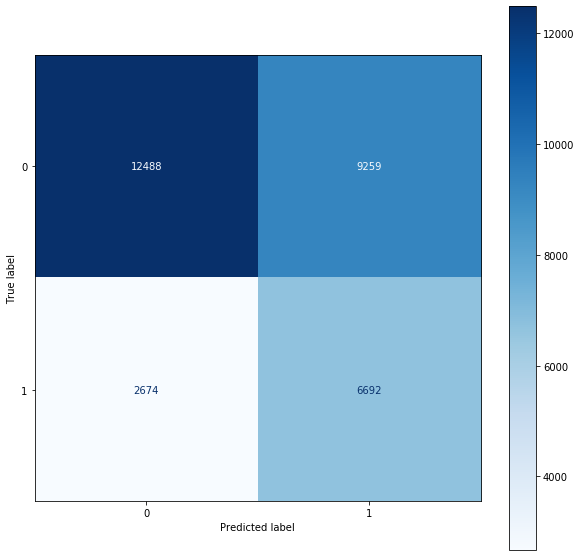

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

classifier = fusion_model
preds = fusion_model.predict(test_union)

np.set_printoptions(precision=2)
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(
    classifier, test_union, test_labels, cmap=plt.cm.Blues, ax=ax
)
# disp.ax_.set_title("Normalized confusion matrix", fontsize=14)
print(disp.confusion_matrix)

plt.savefig("confusion_matrix", dpi=150)
plt.show()

In [65]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, preds))

              precision    recall  f1-score   support

           0       0.82      0.57      0.68     21747
           1       0.42      0.71      0.53      9366

    accuracy                           0.62     31113
   macro avg       0.62      0.64      0.60     31113
weighted avg       0.70      0.62      0.63     31113



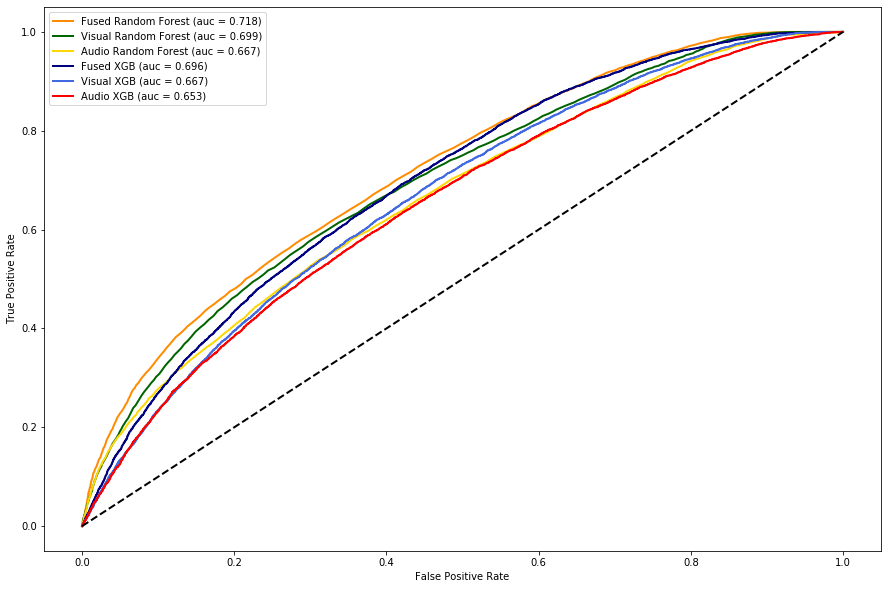

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

plt.figure(figsize=(15, 10))

preds_prob = fusion_model.predict_proba(test_union)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="Fused Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

preds_prob = visual_model.predict_proba(test_visual)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
plt.plot(
    fpr,
    tpr,
    color="darkgreen",
    lw=2,
    label="Visual Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

preds_prob = audio_model.predict_proba(test_audio)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
plt.plot(
    fpr,
    tpr,
    color="gold",
    lw=2,
    label="Audio Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)


preds_prob = fusion_xgb.predict_proba(test_union)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
plt.plot(fpr, tpr, color="navy", lw=2, label="Fused XGB (auc = %0.3f)" % auc(fpr, tpr))

preds_prob = visual_xgb.predict_proba(test_visual)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
plt.plot(
    fpr, tpr, color="royalblue", lw=2, label="Visual XGB (auc = %0.3f)" % auc(fpr, tpr)
)

preds_prob = audio_xgb.predict_proba(test_audio)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
plt.plot(fpr, tpr, color="red", lw=2, label="Audio XGB (auc = %0.3f)" % auc(fpr, tpr))


plt.plot([0, 1], [0, 1], color="black", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.title("ROC curve of the Random Forest classifier applied on the test set", fontsize=14)
plt.legend()
plt.savefig("roc_all", dpi=150)
plt.show()

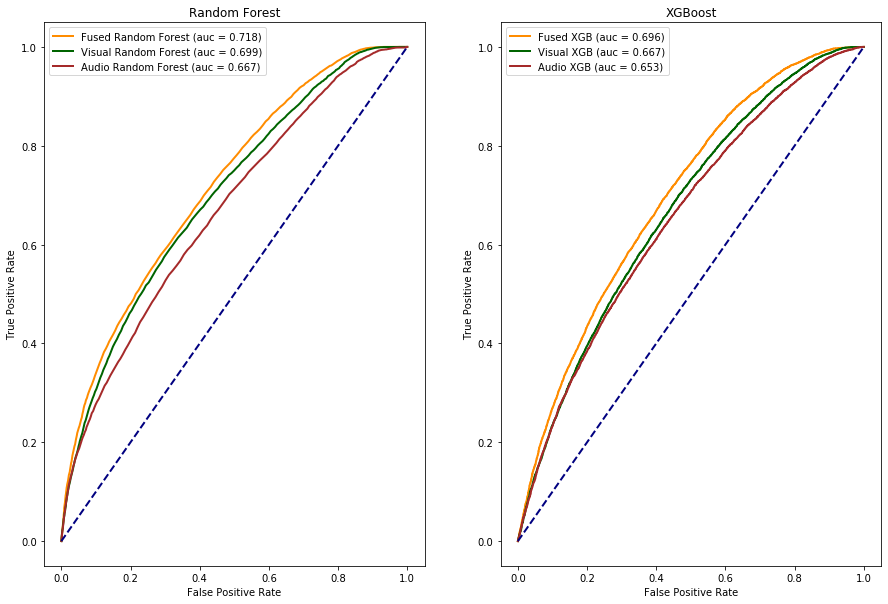

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))


preds_prob = fusion_model.predict_proba(test_union)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
ax1.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="Fused Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

preds_prob = visual_model.predict_proba(test_visual)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
ax1.plot(
    fpr,
    tpr,
    color="darkgreen",
    lw=2,
    label="Visual Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

preds_prob = audio_model.predict_proba(test_audio)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
ax1.plot(
    fpr,
    tpr,
    color="brown",
    lw=2,
    label="Audio Random Forest (auc = %0.3f)" % auc(fpr, tpr),
)

ax1.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")


preds_prob = fusion_xgb.predict_proba(test_union)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
ax2.plot(
    fpr, tpr, color="darkorange", lw=2, label="Fused XGB (auc = %0.3f)" % auc(fpr, tpr)
)

preds_prob = visual_xgb.predict_proba(test_visual)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
ax2.plot(
    fpr, tpr, color="darkgreen", lw=2, label="Visual XGB (auc = %0.3f)" % auc(fpr, tpr)
)

preds_prob = audio_xgb.predict_proba(test_audio)
fpr, tpr, _ = roc_curve(test_labels, preds_prob[:, 1])
ax2.plot(fpr, tpr, color="brown", lw=2, label="Audio XGB (auc = %0.3f)" % auc(fpr, tpr))


ax2.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")

ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.set_title("Random Forest")

ax2.set_xlabel("False Positive Rate")
ax2.set_ylabel("True Positive Rate")
ax2.set_title("XGBoost")
# plt.title("ROC curve of the Random Forest classifier applied on the test set", fontsize=14)
ax1.legend()
ax2.legend()
plt.savefig("roc_separate", dpi=150)
plt.show()

### Post Processing

In [73]:
from scipy.signal import medfilt


def smoothing(predicted, med_thres=5, hard_thres=3):
    """
    Filtering Predictions
    """
    data = predicted.copy()
    data = medfilt(data, med_thres)
    count = 0
    start = -1
    length = len(predicted)
    for idx, item in enumerate(data):
        if item == 1:
            count += 1
            if start == -1:
                start = idx
            if count < hard_thres:
                if idx == length - 1:
                    return data
                elif data[idx + 1] == 0:
                    count = 0
                    data[start : idx + 1] = 0
        if item == 0:
            start = -1
            count = 0
    return data

In [54]:
thresholds = [3, 5]
pres = {}
recs = {}
f1 = {}
acc = {}
for threshold in thresholds:
    preds_thres = smoothing(preds, 3, threshold)
    pre = precision_score(test_labels, preds_thres)
    pres[threshold] = 100 * pre
    rec = recall_score(test_labels, preds_thres)
    recs[threshold] = 100 * rec
    f1[threshold] = 100 * f1_score(test_labels, preds_thres, average="macro")
    acc[threshold] = 100 * accuracy_score(test_labels, preds_thres)

In [55]:
print(pres)

{3: 51.24708624708625, 5: 53.945111492281306}


In [56]:
print(recs)

{3: 46.946401879137305, 5: 40.29468289557976}


In [57]:
print(f1)

{3: 64.16704494694562, 5: 63.4567963599081}


In [58]:
print(acc)

{3: 70.58464307524186, 5: 71.67100568894031}


In [59]:
f1_score(test_labels, preds, average="macro")

0.6233517803123089

## Video Level Testing

In [61]:
trainining_size = int(0.8 * len(labels_matrix))

video_labels = labels_matrix[trainining_size:]
video_test = [
    np.hstack((visual, audio))
    for visual, audio in zip(
        visual_matrix[trainining_size:], audio_matrix[trainining_size:]
    )
]

In [75]:
model = fusion_model
pres = []
recs = []
for features, labels in zip(video_test, video_labels):
    preds = model.predict(features)
    preds = smoothing(preds, 3, 5)
    pre = precision_score(labels, preds)
    pres.append(100 * pre)
    rec = recall_score(labels, preds)
    recs.append(100 * rec)

/home/lorki/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lorki/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lorki/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


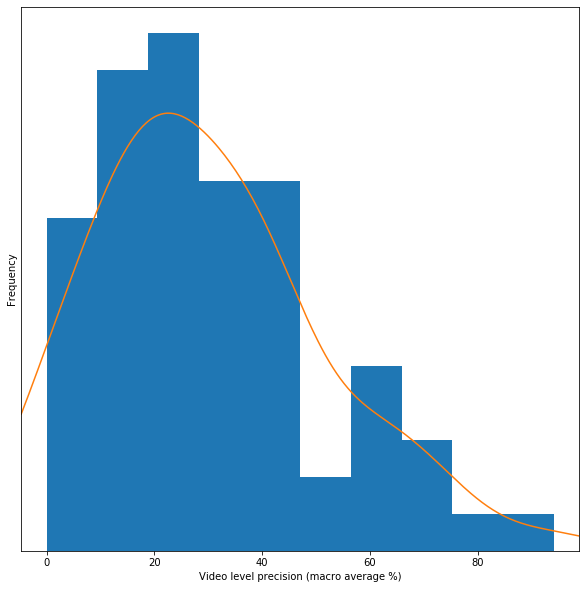

In [76]:
import scipy.stats as st
import matplotlib.pyplot as plt

x = pres
plt.figure(figsize=(10, 10))
plt.hist(x, density=True)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs))
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
plt.ylabel("Frequency")
plt.xlabel("Video level precision (macro average %)")
plt.savefig("precision_hist", dpi=150)

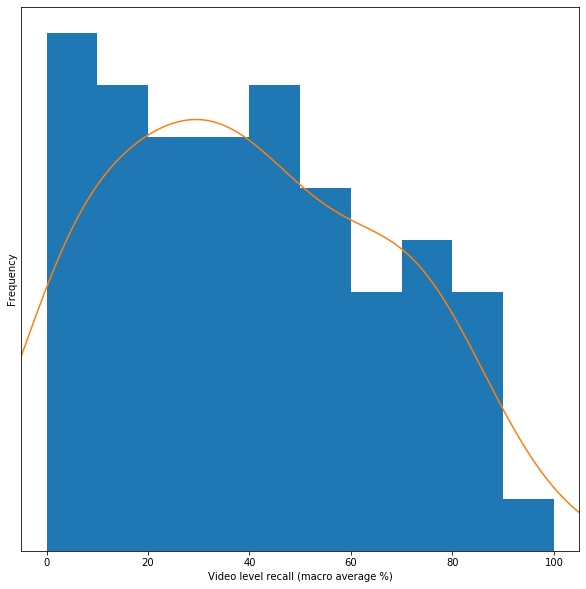

In [77]:
import scipy.stats as st
import matplotlib.pyplot as plt

x = recs
plt.figure(figsize=(10, 10))
plt.hist(x, density=True)
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 300)
kde = st.gaussian_kde(x)
plt.plot(kde_xs, kde.pdf(kde_xs))
ax = plt.gca()
ax.axes.yaxis.set_ticks([])
plt.ylabel("Frequency")
plt.xlabel("Video level recall (macro average %)")
plt.savefig("recall_hist", dpi=150)
plt.show()

In [85]:
def video_level_accuracy(model, labels_list, features_list, acc_thres=0.85):
    cnt = 0
    for features, labels in zip(features_list, labels_list):
        preds = model.predict(features)
        preds = smoothing(preds, 3, 5)
        acc = accuracy_score(labels, preds)
        if acc >= acc_thres:
            cnt += 1
    return cnt / len(labels_list)

In [88]:
model = fusion_model
accuracy = video_level_accuracy(model, video_labels, video_test, acc_thres=0.6)
print(f"--> Video level accuracy of the best classifier if: {accuracy * 100:.2f} %")

--> Video level accuracy of the best classifier if: 35.29 %
